# DDPG - Deep Deterministic Policy Gradients Algorithm


In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## DDPG structure
The algorithm consists of 4 networks. 

- Q Network
- Deterministic policy function
- target Q Network
- target policy network

Using the same principle as described in DQN, 
online networks are used for direct experiences sampled randomly from the replay buffer. 
Target networks are updated every N steps. The difference with DQN is that instead of executing hard update DDPG uses soft one.

DDPG allows to work with continues output, when vanila DQN is not suited for such task

In [2]:
import gym

env = gym.make('Pendulum-v0')
env

<TimeLimit<PendulumEnv<Pendulum-v0>>>

In [3]:
# Random agent

state = env.reset()
done = False

total_reward = 0
while not done:
    action = np.random.random_sample(env.action_space.shape[0])
    state, reward, done, _ = env.step(action)
    total_reward += reward
    env.render()

print(f'Total reward {total_reward}')
env.close()

Total reward -952.185086450828


### Actor Network

Actor network is used for constant action on environment. 

In [46]:
import torch.nn.functional as f


class Actor(nn.Module):

    def __init__(self, inputs, outputs, hidden_layers=(128, 256)):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden_layers[0])
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        nn.init.uniform_(self.fc1.bias.data, -f1, f1)

        self.bn1 = nn.LayerNorm(hidden_layers[0])
        self.hidden_layers = nn.ModuleList()
        self.hidden_norms = nn.ModuleList()
        for i in range(len(hidden_layers)-1):
            self.hidden_layers.append(
                nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            fn = 1 / np.sqrt(self.hidden_layers[i].weight.data.size()[0])
            nn.init.uniform_(self.hidden_layers[i].weight.data, -fn, fn)
            nn.init.uniform_(self.hidden_layers[i].bias.data, -fn, fn)
            self.hidden_norms.append(nn.LayerNorm(hidden_layers[i+1]))

        self.output = nn.Linear(hidden_layers[-1], outputs)

    def forward(self, X):
        X = f.relu(self.bn1(self.fc1(X)))
        for i in range(len(self.hidden_layers)):
            X = f.relu(self.hidden_norms[i](self.hidden_layers[i](X)))

        return torch.tanh(self.output(X))


### Critic Network

Critic network is used for criticizing Actor by soft updates every once in awhile.

In [47]:
class Critic(nn.Module):

    def __init__(self, inputs, outputs, hidden_layers=(128, 256)):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden_layers[0])
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        nn.init.uniform_(self.fc1.bias.data, -f1, f1)

        self.bn1 = nn.LayerNorm(hidden_layers[0])
        self.hidden_layers = nn.ModuleList()
        self.hidden_norms = nn.ModuleList()
        for i in range(len(hidden_layers)-1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            fn = 1 / np.sqrt(self.hidden_layers[i].weight.data.size()[0])
            nn.init.uniform_(self.hidden_layers[i].weight.data, -fn, fn)
            nn.init.uniform_(self.hidden_layers[i].bias.data, -fn, fn)
            self.hidden_norms.append(nn.LayerNorm(hidden_layers[i+1]))
        self.output = nn.Linear(hidden_layers[-1], outputs)

    def forward(self, X1, X2):
        X = torch.cat([X1, X2], 1) # concatenate states and actions by columns
        X = f.relu(self.bn1(self.fc1(X)))
        for i in range(len(self.hidden_layers)):
            X = f.relu(self.hidden_norms[i](self.hidden_layers[i](X)))
        
        return self.output(X)

### Replay Buffer

Replay Buffer serves as a storage for sampling data points. Samples are drawn randomly to achieve IID - Independent and Identical Distribution

In [48]:
from collections import deque
import random

class ReplayBuffer():

    def __init__(self, cap=128):
        self.buffer = deque(maxlen=cap)

    def add(self, state, action, reward, next_state, done):
        exp = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(exp)
        

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.vstack(states), np.vstack(actions), np.vstack(rewards), np.vstack(next_states), np.vstack(dones)

    def __len__(self):
        return len(self.buffer)


In [49]:
# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


# # https://github.com/openai/gym/blob/master/gym/core.py
# class NormalizedEnv(gym.ActionWrapper):
#     """ Wrap action """

#     def action(self, action):
#         act_k = (self.action_space.high - self.action_space.low)/ 2.
#         act_b = (self.action_space.high + self.action_space.low)/ 2.
#         return act_k * action + act_b

#     def reverse_action(self, action):
#         act_k_inv = 2./(self.action_space.high - self.action_space.low)
#         act_b = (self.action_space.high + self.action_space.low)/ 2.
#         return act_k_inv * (action - act_b)
        

Starting episode 0
Episode 0 reward -1127.5852939675574
Starting episode 1
Episode 1 reward -1275.2019979516087
Starting episode 2
Episode 2 reward -1464.738815288283
Starting episode 3
Episode 3 reward -1283.4500187162168
Starting episode 4
Episode 4 reward -1251.9774816637907
Starting episode 5
Episode 5 reward -1039.6582267358133
Starting episode 6
Episode 6 reward -1284.5550016646787
Starting episode 7
Episode 7 reward -744.2634408426821
Starting episode 8
Episode 8 reward -379.44555789173387
Starting episode 9
Episode 9 reward -126.09551740950124
Starting episode 10
Episode 10 reward -746.6628669555488
Starting episode 11
Episode 11 reward -377.0779718428912
Starting episode 12
Episode 12 reward -498.3449150804192
Starting episode 13
Episode 13 reward -1052.6282204261033
Starting episode 14
Episode 14 reward -617.7399213133202
Starting episode 15
Episode 15 reward -1005.5921164672241
Starting episode 16
Episode 16 reward -627.9014961238046
Starting episode 17
Episode 17 reward -74

Text(0, 0.5, 'Reward')

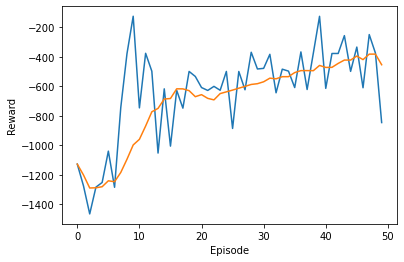

In [50]:
import torch.optim as optim

# traning routine
EPISODES = 50
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 1e-2

env = gym.make("Pendulum-v0") 
noise = OUNoise(env.action_space)

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

actor = Actor(num_states, num_actions, hidden_layers=(256,256))
target_actor = Actor(num_states, num_actions, hidden_layers=(256,256))
# hard copy
for target_param, param in zip(target_actor.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)

critic = Critic(num_states + num_actions, num_actions, hidden_layers=(256,256))
target_critic = Critic(num_states + num_actions, num_actions, hidden_layers=(256,256))
for param, target_param in zip(target_critic.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)

criterion = nn.MSELoss()
actor_optim = optim.Adam(actor.parameters(), lr=1e-4)
critic_optim = optim.Adam(critic.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer(cap=50000)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f'using {device} as device')

# actor.to(device)
# target_actor.to(device)
# critic.to(device)
# target_critic.to(device)

def update_agent():
    states, actions, rewards, next_states, _ = replay_buffer.sample(BATCH_SIZE)
    states = torch.from_numpy(states).float() #.to(device)
    actions = torch.from_numpy(actions).float()# .to(device)
    rewards = torch.from_numpy(rewards).float()# .to(device)
    next_states = torch.from_numpy(next_states).float() #.to(device)

    qval = critic.forward(states, actions)
    next_actions = target_actor.forward(next_states)
    nextQ = target_critic.forward(next_states, next_actions.detach())
    qprime = rewards + GAMMA * nextQ

    critic_loss = criterion(qval, qprime)
    actor_loss = -critic.forward(states, actor.forward(states)).mean()

    actor_optim.zero_grad()
    actor_loss.backward()
    actor_optim.step()

    critic_optim.zero_grad()
    critic_loss.backward()
    critic_optim.step()

    for target_param, param in zip(target_actor.parameters(), actor.parameters()):
        target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

    for target_param, param in zip(target_critic.parameters(), critic.parameters()):
        target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

@torch.no_grad()
def get_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0) #.to(device)
    action = actor.forward(state)
    return action.cpu().detach().numpy()[0]

rewards = []
avg_rewards = []
for i in range(EPISODES):
    print(f'Starting episode {i}')
    state = env.reset()
    noise.reset()
    ep_reward = 0
    step = 0
    while True:
        step += 1
        action = get_action(state)
        action = noise.get_action(action, step)
        # print(f'Selected action {action}')
        next_state, reward, done, _ = env.step(action)

        # add new data to replay buffer
        replay_buffer.add(state, action, reward, next_state, done)
        if len(replay_buffer) > BATCH_SIZE:
            update_agent()

        ep_reward += reward
        state = next_state
        if done:
            break

    print(f'Episode {i} reward {ep_reward}')
    rewards.append(ep_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    if avg_rewards[-1] > -250:
        print(f'Early stop at episode {i}')
        break
    
plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')

In [52]:
# testing 
state = env.reset()
ep_reward = 0
while True:
    state = torch.from_numpy(state).float().unsqueeze(0) #.to(device)
    action = target_actor.forward(state)
    action = action.cpu().detach().numpy()[0]
    # print(f'Selected action {action}')
    next_state, reward, done, _ = env.step(action)
    env.render()
    ep_reward += reward
    state = next_state
    if done:
        break

env.close()